# 必要なパッケージのインポート

In [1]:
import os # tensorboardの出力先作成
import matplotlib.pyplot as plt # 可視化
import numpy as np # 計算
import torch # 機械学習フレームワークとしてpytorchを使用
import torch.nn as nn # クラス内で利用するモジュールのため簡略化
import torch.nn.functional as F # クラス内で利用するモジュールのため簡略化
from torch import optim # 最適化アルゴリズム
from torch.utils.tensorboard import SummaryWriter # tensorboardの利用
from torchvision import datasets, transforms # データセットの準備

# GPU使用の手続き

In [2]:
# GPUが使える場合はGPU上で動かす
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# tensorboardのログの保存先
if not os.path.exists("../logs/VAE"):
    os.makedirs("../logs/VAE")

# データセットの取得、加工

In [3]:
# MNISTのデータをとってくるときに一次元化する前処理
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
# trainデータとtestデータに分けてデータセットを取得
dataset_train_valid = datasets.MNIST("../", train=True, download=True, transform=transform)
dataset_test = datasets.MNIST("../", train=False, download=True, transform=transform)
# trainデータの20%はvalidationデータとして利用
size_train_valid = len(dataset_train_valid) # 60000
size_train = int(size_train_valid * 0.8) # 48000
size_valid = size_train_valid - size_train # 12000
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train_valid, [size_train, size_valid])
# 取得したデータセットをDataLoader化する
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1000, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1000, shuffle=False)

# VAEモデル

In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        """コンストラクタ

        Args:
            z_dim (int): 潜在空間の次元数

        Returns:
            None.

        Note:
            eps (float): オーバーフローとアンダーフローを防ぐための微小量
        """
        super(VAE, self).__init__() # VAEクラスはnn.Moduleを継承しているため親クラスのコンストラクタを呼ぶ必要がある
        self.eps = np.spacing(1) # オーバーフローとアンダーフローを防ぐための微小量
        self.x_dim = 28 * 28 # MNISTの場合は28×28の画像であるため
        self.z_dim = z_dim # インスタンス化の際に潜在空間の次元数は自由に設定できる
        self.enc_fc1 = nn.Linear(self.x_dim, 400) # エンコーダ1層目
        self.enc_fc2 = nn.Linear(400, 200) # エンコーダ2層目
        self.enc_fc3_mean = nn.Linear(200, z_dim) # 近似事後分布の平均
        self.enc_fc3_logvar = nn.Linear(200, z_dim) # 近似事後分布の分散の対数
        self.dec_fc1 = nn.Linear(z_dim, 200) # デコーダ1層目
        self.dec_fc2 = nn.Linear(200, 400) # デコーダ2層目
        self.dec_drop = nn.Dropout(p=0.2) # 過学習を防ぐために最終層の直前にドロップアウト
        self.dec_fc3 = nn.Linear(400, self.x_dim) # デコーダ3層目

    def encoder(self, x):
        """エンコーダ

        Args:
            x (torch.tensor): (バッチサイズ, 入力次元数)サイズの入力データ

        Returns:
            mean (torch.tensor): 近似事後分布の平均
            logvar (torch.tensor): 近似事後分布の分散の対数
        """
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        return self.enc_fc3_mean(x), self.enc_fc3_logvar(x)

    def sample_z(self, mean, log_var, device):
        """Reparameterization trickに基づく潜在変数Zの疑似的なサンプリング

        Args:
            mean (torch.tensor): 近似事後分布の平均
            logvar (torch.tensor): 近似事後分布の分散の対数
            device (String): GPUが使える場合は"cuda"でそれ以外は"cpu"

        Returns:
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数
        """
        epsilon = torch.randn(mean.shape, device=device)
        return mean + epsilon * torch.exp(0.5 * log_var)

    def decoder(self, z):
        """デコーダ

        Args:
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数

        Returns:
            y (torch.tensor): (バッチサイズ, 入力次元数)サイズの再構成データ
        """
        z = F.relu(self.dec_fc1(z))
        z = F.relu(self.dec_fc2(z))
        z = self.dec_drop(z)
        return torch.sigmoid(self.dec_fc3(z))

    def forward(self, x, device):
        """順伝播処理

        Args:
            x (torch.tensor): (バッチサイズ, 入力次元数)サイズの入力データ
            device (String): GPUが使える場合は"cuda"でそれ以外は"cpu"

        Returns:
            KL (torch.float): KLダイバージェンス
            reconstruction (torch.float): 再構成誤差
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数
            y (torch.tensor): (バッチサイズ, 入力次元数)サイズの再構成データ            
        """
        mean, log_var = self.encoder(x.to(device)) # encoder部分
        z = self.sample_z(mean, log_var, device) # Reparameterization trick部分
        y = self.decoder(z.to(device)).to(device) # decoder部分
        KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var)) # KLダイバージェンス計算
        reconstruction = torch.sum(x.to(device) * torch.log(y.to(device) + self.eps) + (1 - x.to(device)) * torch.log(1 - y.to(device) + self.eps)) # 再構成誤差計算
        return [KL, reconstruction], z, y

# ハイパーパラメータの設定

In [5]:
# VAEクラスのコンストラクタに潜在変数の次元数を渡す
model = VAE(2).to(device)
# 今回はoptimizerとしてAdamを利用
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 最大更新回数は1000回
num_epochs = 1000
# 検証データのロスとその最小値を保持するための変数を十分大きな値で初期化しておく
loss_valid = 10 ** 7
loss_valid_min = 10 ** 7

# 学習

In [6]:
# early stoppingを判断するためのカウンタ変数
num_no_improved = 0
# tensorboardに記録するためのカウンタ変数
num_batch_train = 0
num_batch_valid = 0
# tensorboardでモニタリングする
writer = SummaryWriter(log_dir="../logs/VAE")
# 学習開始
for num_iter in range(num_epochs):
    model.train() # 学習前は忘れずにtrainモードにしておく
    for x, t in dataloader_train: # dataloaderから訓練データを抽出する
        lower_bound, _, _ = model(x, device) # VAEにデータを流し込む
        loss = -sum(lower_bound) # lossは負の下限
        model.zero_grad() # 訓練時のpytorchのお作法
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss_train/KL", -lower_bound[0].cpu().detach().numpy(), num_iter + num_batch_train)
        writer.add_scalar("Loss_train/Reconst", -lower_bound[1].cpu().detach().numpy(), num_iter + num_batch_train)
        num_batch_train += 1
    num_batch_train -= 1 # 次回のエポックでつじつまを合わせるための調整

    # 検証開始
    model.eval() # 検証前は忘れずにevalモードにしておく
    loss = []
    for x, t in dataloader_valid: # dataloaderから検証データを抽出する
        lower_bound, _, _ = model(x, device) # VAEにデータを流し込む
        loss.append(-sum(lower_bound).cpu().detach().numpy())
        writer.add_scalar("Loss_valid/KL", -lower_bound[0].cpu().detach().numpy(), num_iter + num_batch_valid)
        writer.add_scalar("Loss_valid/Reconst", -lower_bound[1].cpu().detach().numpy(), num_iter + num_batch_valid)
        num_batch_valid += 1
    num_batch_valid -= 1 # 次回のエポックでつじつまを合わせるための調整
    loss_valid = np.mean(loss)
    loss_valid_min = np.minimum(loss_valid_min, loss_valid)
    print(f"[EPOCH{num_iter + 1}] loss_valid: {int(loss_valid)} | Loss_valid_min: {int(loss_valid_min)}")

    # もし今までのlossの最小値よりも今回のイテレーxションのlossが大きければカウンタ変数をインクリメントする
    if loss_valid_min < loss_valid:
        num_no_improved += 1
        print(f"{num_no_improved}回連続でValidationが悪化しました")
    # もし今までのlossの最小値よりも今回のイテレーションのlossが同じか小さければカウンタ変数をリセットする
    else:
        num_no_improved = 0
        if not os.path.exists("../saved_model/VAE/"):
            os.makedirs("../saved_model/VAE/")
        torch.save(model.state_dict(), f"../saved_model/VAE/z_{model.z_dim}.pth")
    # カウンタ変数が10回に到達したらearly stopping
    if (num_no_improved >= 10):
        print(f"{num_no_improved}回連続でValidationが悪化したため学習を止めます")
        break
# tensorboardのモニタリングも停止しておく
writer.close()

2023-07-12 13:53:37.902092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 13:53:38.444753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[EPOCH1] loss_valid: 206322 | Loss_valid_min: 206322
[EPOCH2] loss_valid: 194831 | Loss_valid_min: 194831
[EPOCH3] loss_valid: 180193 | Loss_valid_min: 180193
[EPOCH4] loss_valid: 175151 | Loss_valid_min: 175151
[EPOCH5] loss_valid: 172504 | Loss_valid_min: 172504
[EPOCH6] loss_valid: 170441 | Loss_valid_min: 170441
[EPOCH7] loss_valid: 168385 | Loss_valid_min: 168385
[EPOCH8] loss_valid: 166734 | Loss_valid_min: 166734
[EPOCH9] loss_valid: 165075 | Loss_valid_min: 165075
[EPOCH10] loss_valid: 163318 | Loss_valid_min: 163318
[EPOCH11] loss_valid: 161419 | Loss_valid_min: 161419
[EPOCH12] loss_valid: 160177 | Loss_valid_min: 160177
[EPOCH13] loss_valid: 159076 | Loss_valid_min: 159076
[EPOCH14] loss_valid: 157725 | Loss_valid_min: 157725
[EPOCH15] loss_valid: 156980 | Loss_valid_min: 156980
[EPOCH16] loss_valid: 156014 | Loss_valid_min: 156014
[EPOCH17] loss_valid: 155448 | Loss_valid_min: 155448
[EPOCH18] loss_valid: 154956 | Loss_valid_min: 154956
[EPOCH19] loss_valid: 154146 | Loss_v

# tensorboardでの可視化

In [7]:
!tensorboard --logdir ../logs/VAE --port 6003 --bind_all

2023-07-12 14:06:33.817809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.29' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by /opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /opt/conda/lib/python3.10/site-packa

# 潜在変数の可視化

/tmp/ipykernel_72/2412489808.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plot.show()
/tmp/ipykernel_72/2412489808.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plot.show()
/tmp/ipykernel_72/2412489808.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plot.show()
/tmp/ipykernel_72/2412489808.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plot.show()
/tmp/ipykernel_72/2412489808.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plot.show()
/tmp/ipykernel_72/2412489

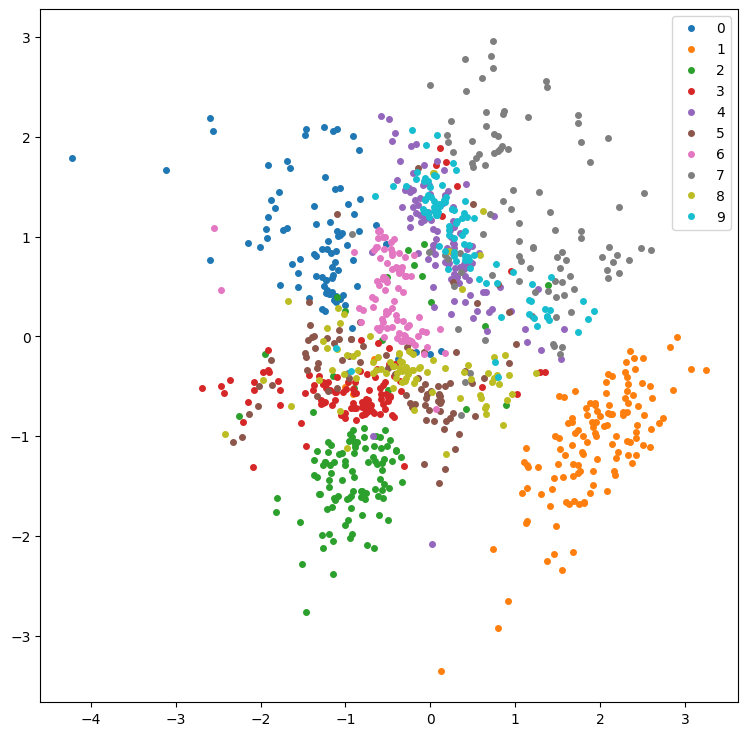

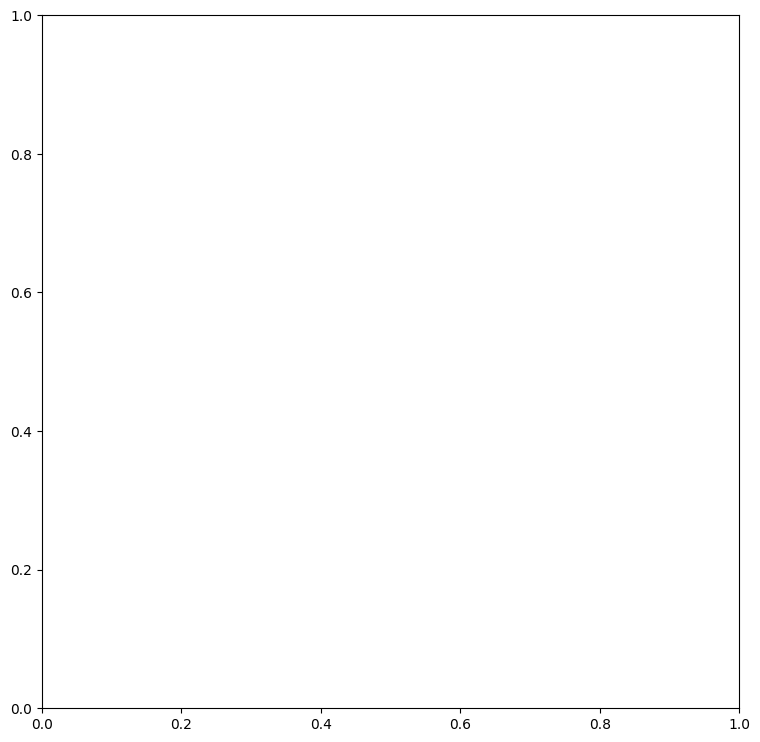

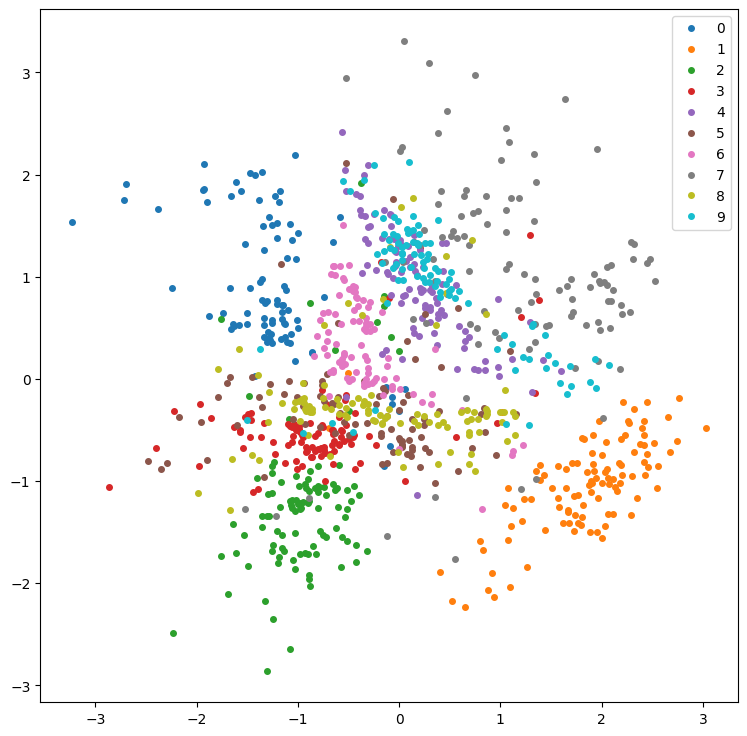

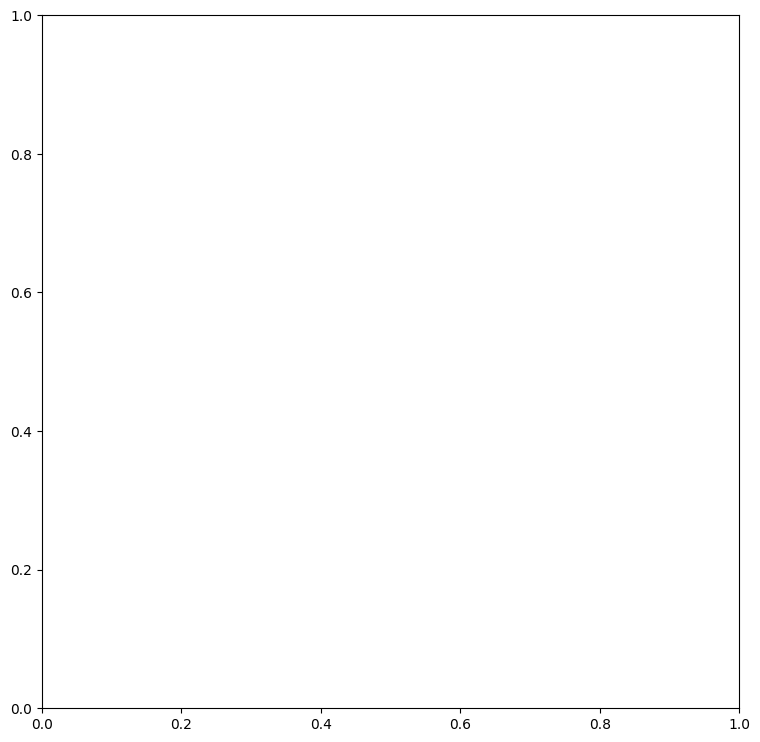

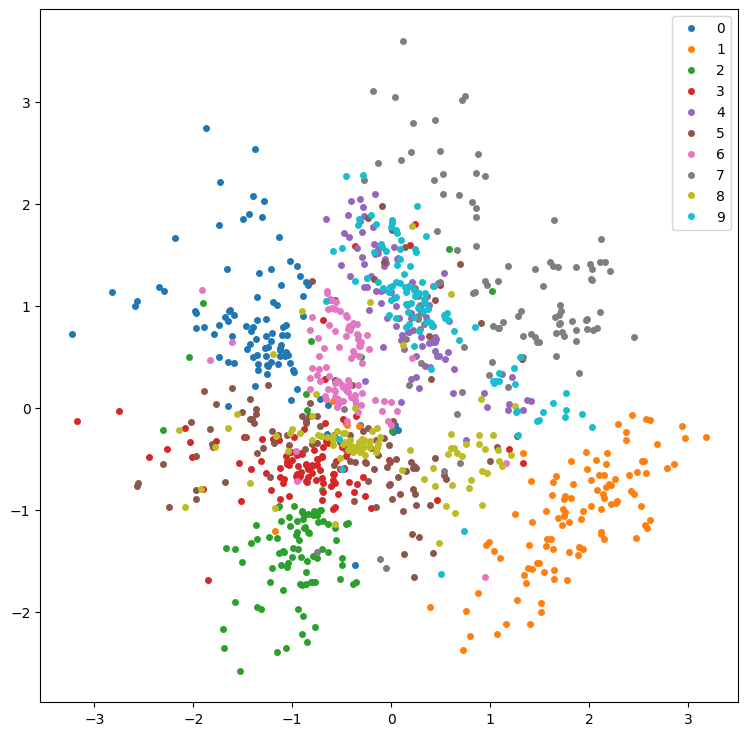

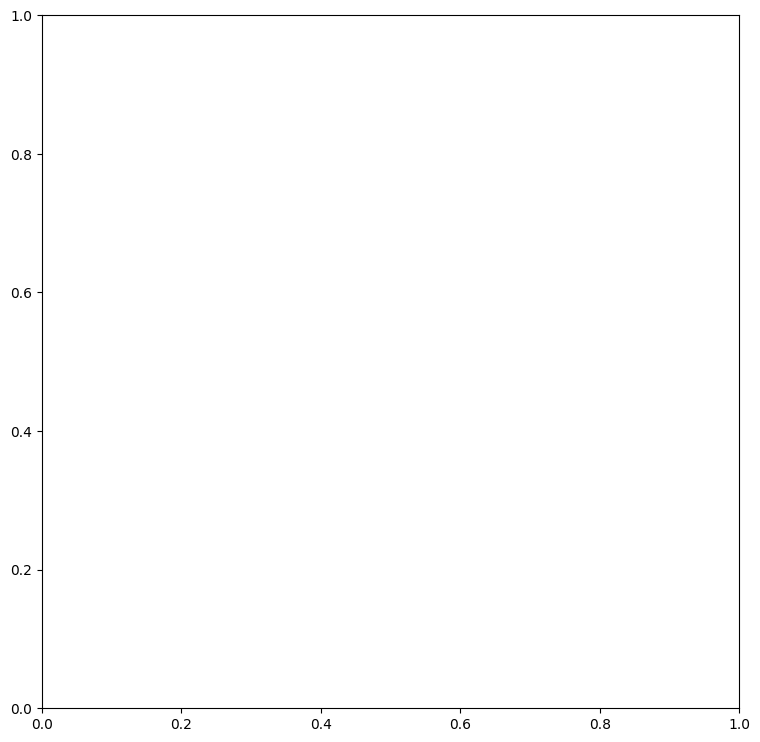

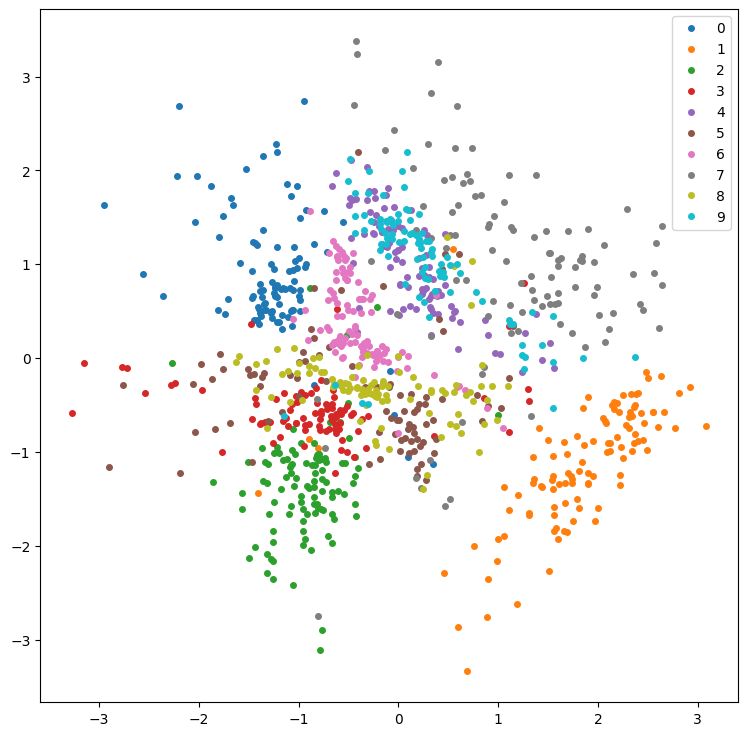

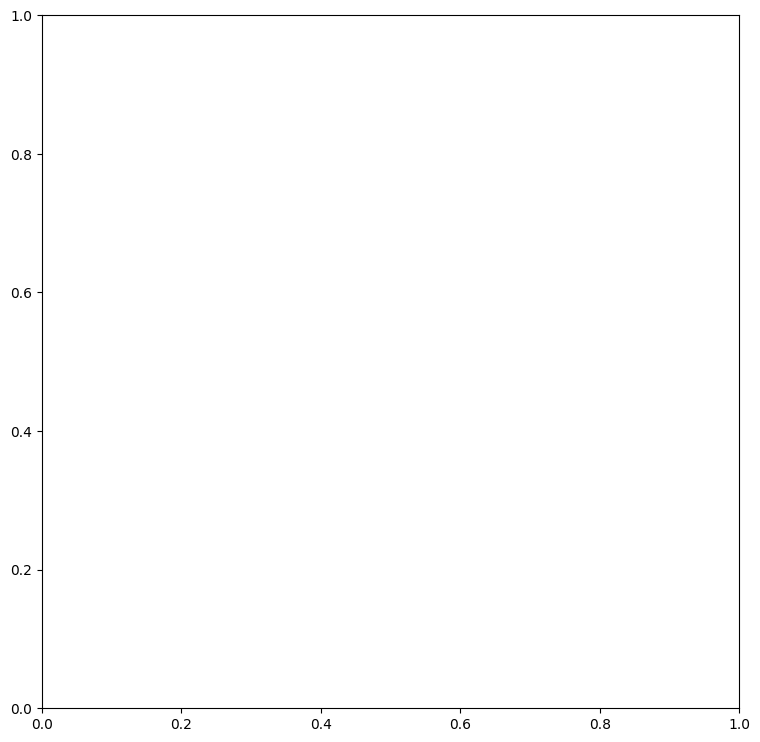

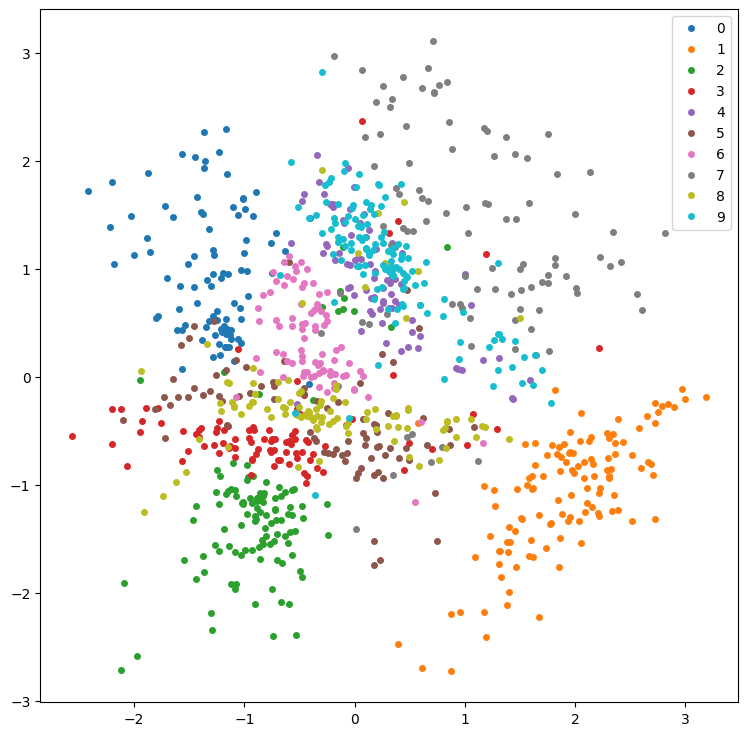

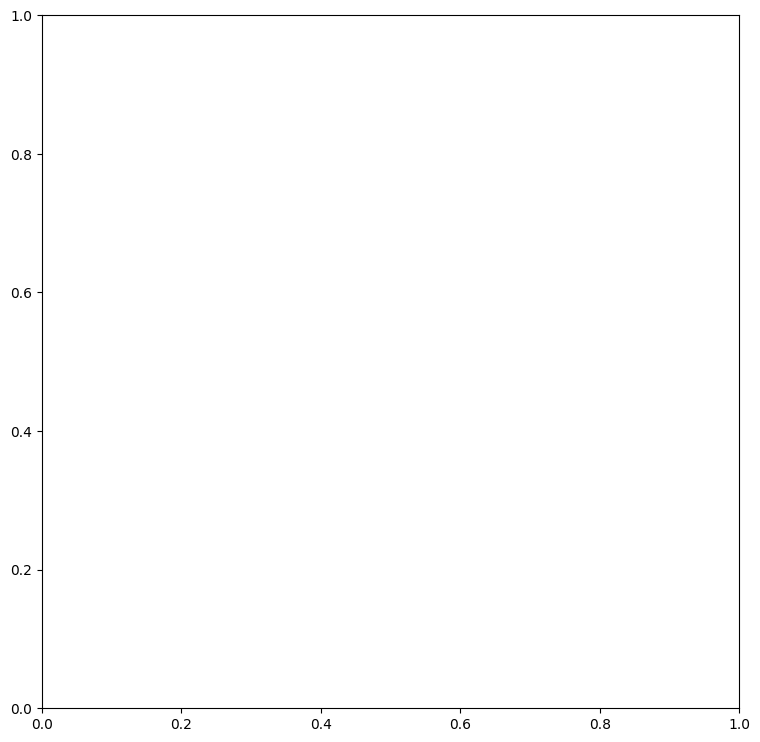

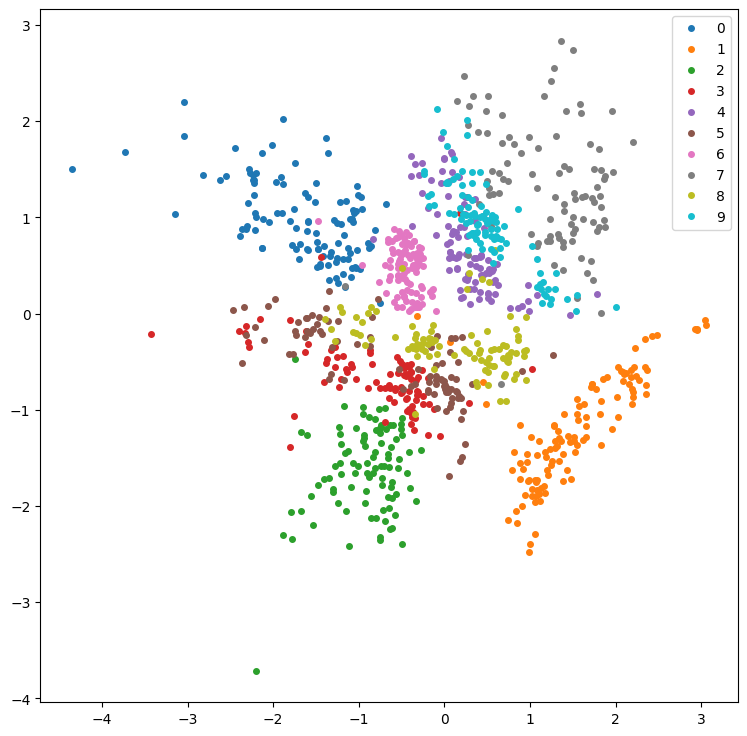

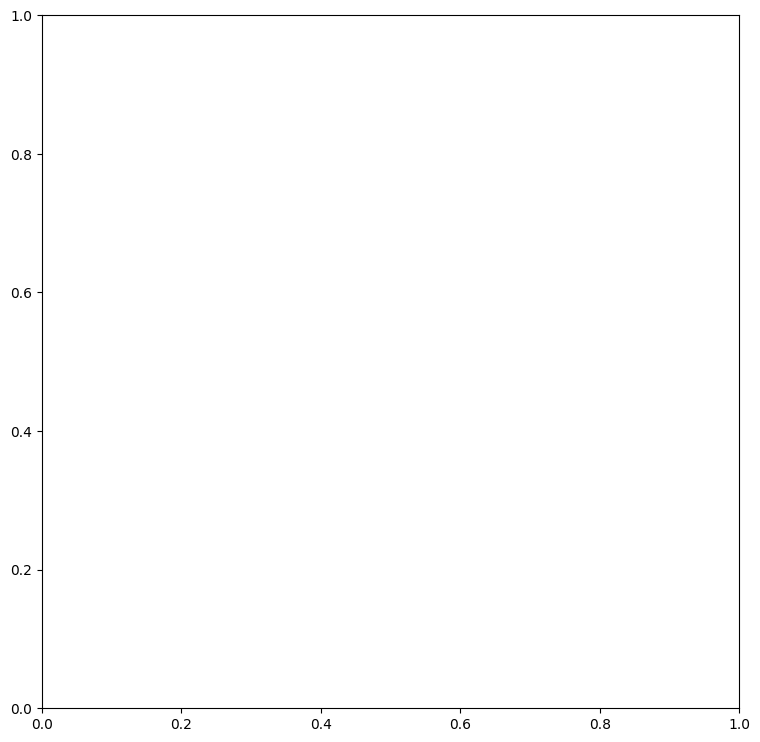

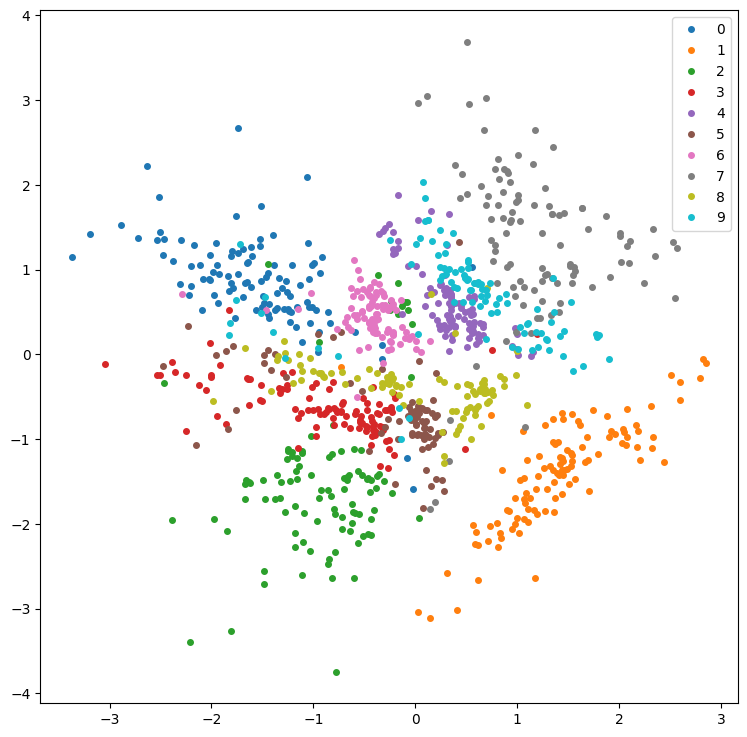

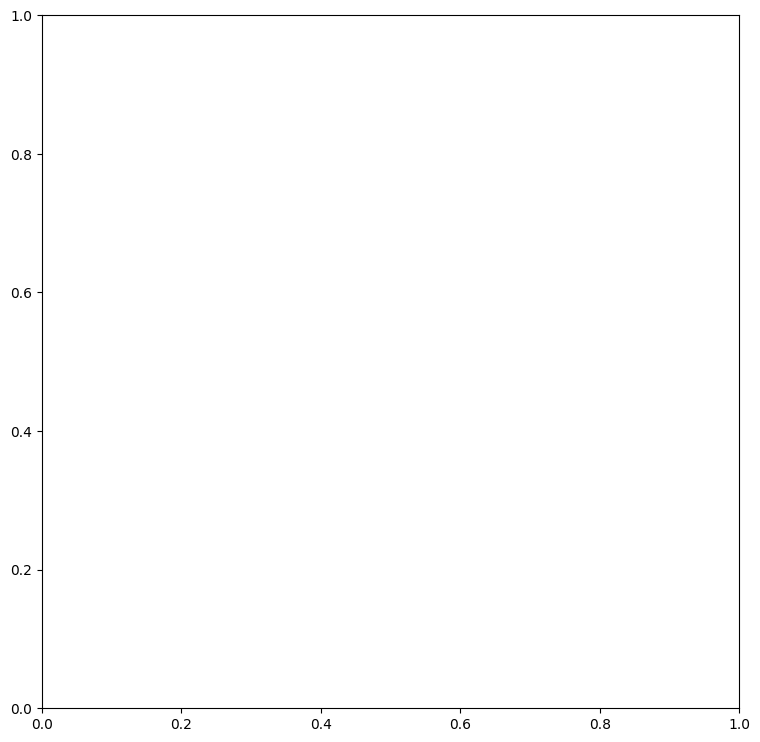

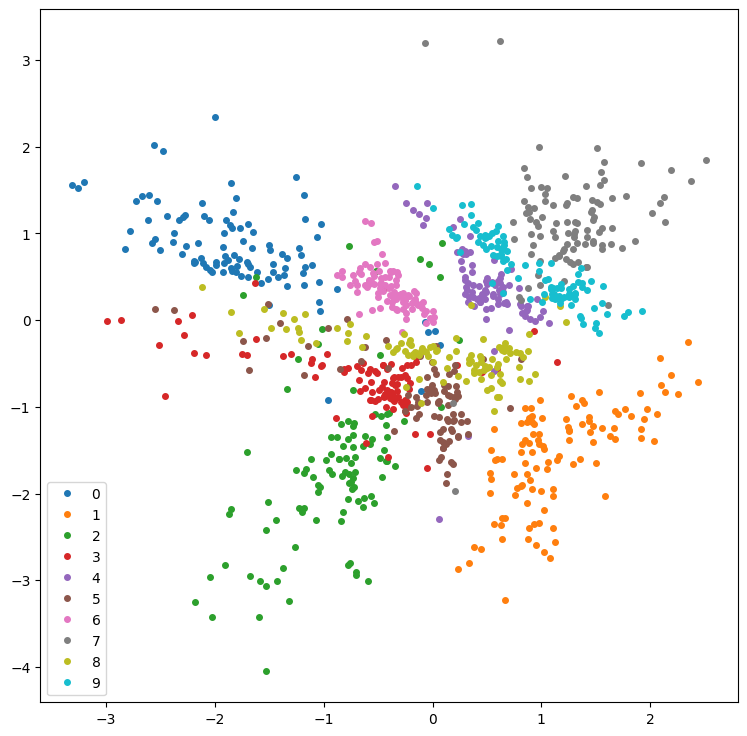

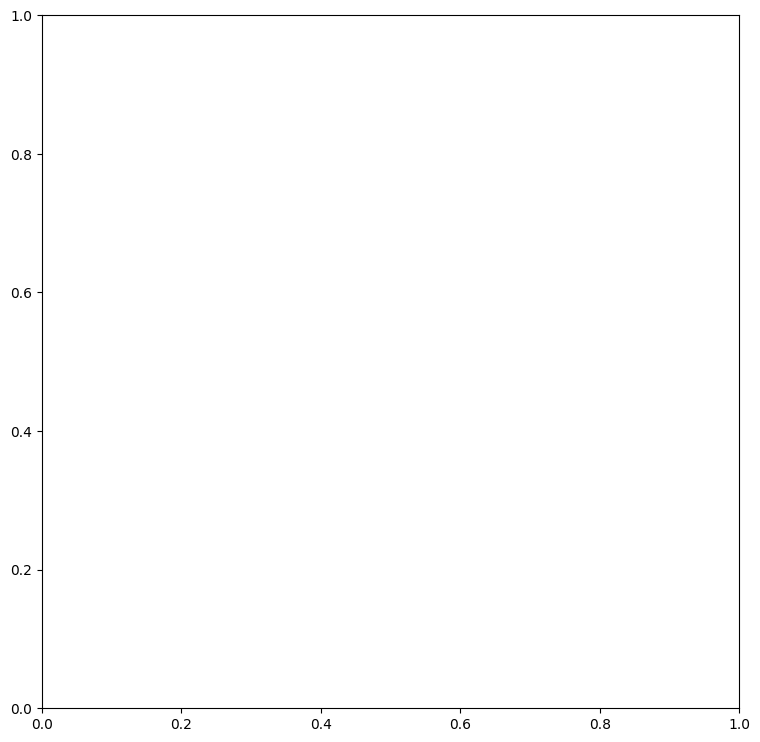

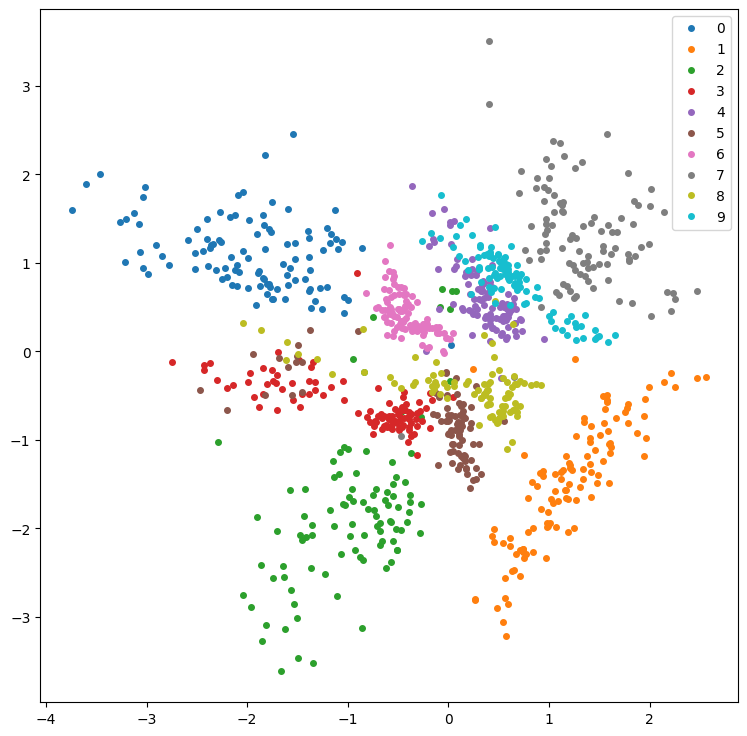

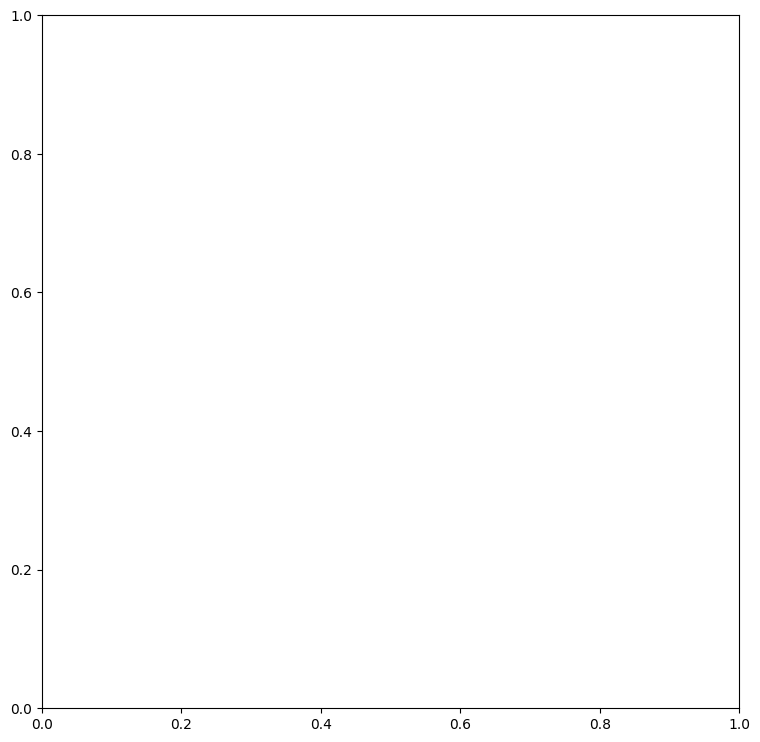

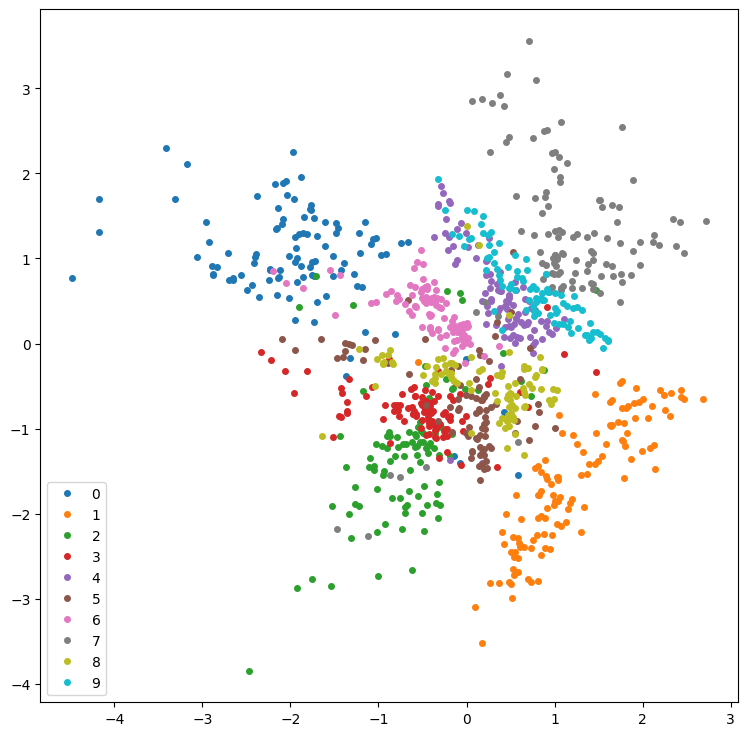

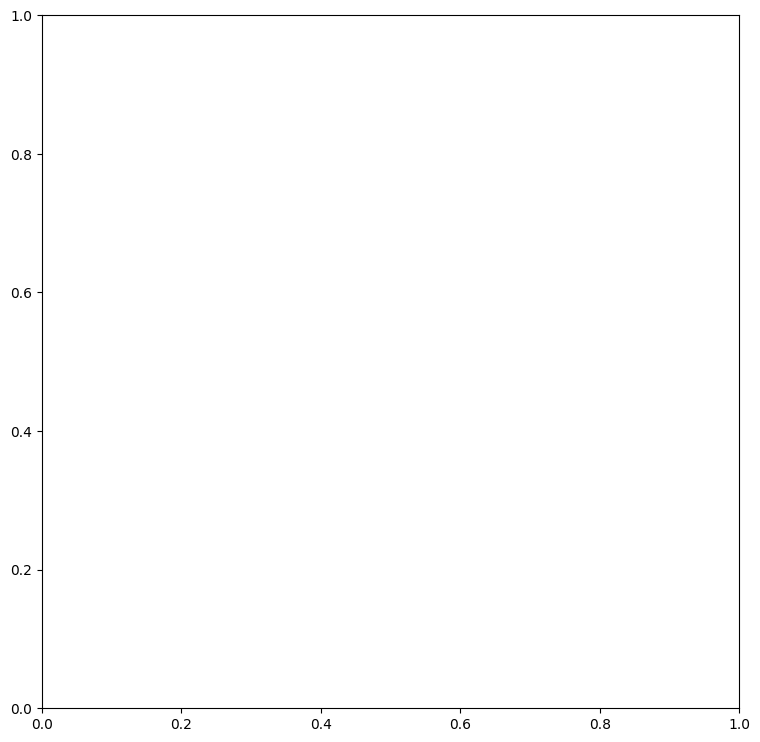

In [55]:
device="cpu"
z_dim = 2
model = VAE(z_dim)
model.load_state_dict(torch.load("../saved_model/VAE/z_2.pth"))
cm = plt.get_cmap("tab10") # カラーマップの用意
# 可視化開始
for num_batch, data in enumerate(dataloader_test):
    fig_plot, ax_plot = plt.subplots(figsize=(9, 9))
    fig_scatter, ax_scatter = plt.subplots(figsize=(9, 9))
    # 学習済みVAEに入力を与えたときの潜在変数を抽出
    _, z, _ = model(data[0], device)
    z = z.cpu().detach().numpy()
    # 各クラスごとに可視化する
    for k in range(10):
        cluster_indexes = np.where(data[1].detach().numpy() == k)[0]
        ax_plot.plot(z[cluster_indexes,0], z[cluster_indexes,1], "o", ms=4, color=cm(k), label=k)
        ax_plot.legend()
    fig_plot.show()